In [1]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree

In [16]:
df=pd.read_csv('Telco-Customer-Churn.csv')
print(df.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Dapat diketahui dari hasil diatas terdapat 7043 row data dengan rincian bahwa rata-rata tenure adalah 32.37 month, sedangkan untuk MonthlyCharges rata-ratanya sebesar 64.76.

percentil 25% adalah 9, mengindikasikan bahwa jika terdapat nilai dibawah nilai persentile 25% maka akan terdeteksi sebagai outlier
percentil 75% adalah 55, hal tersebut mengindikasikan bahwa apabila terdapat tenure yang memiliki nilai diatas 55 akan terdeteksi sebagai outlier

std. deviasi pada kolom tenure adalah sebesar 24,5 mengartikan bahwa ukuran sebaran datanya memiliki kecenderungan diatas nilai mean dengan maksimal 24,5 dan dibawah nilai mean minimal 24,5.

# EXPLORATORY DATA ANALYSIS

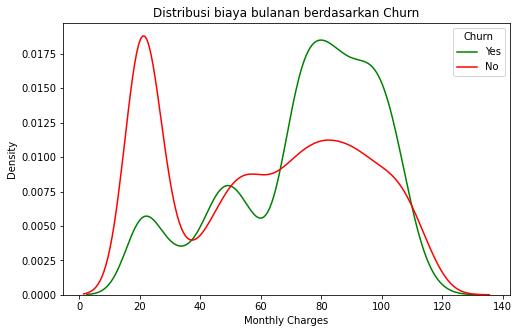

In [4]:
#Untuk mengetahui apakah pelanggan yang memiliki biaya bulanan lebih tinggi akan cenderung churn atau tidak
churn_yes=df[df['Churn']=='Yes']
churn_no=df[df['Churn']=='No']


fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.kdeplot(churn_yes['MonthlyCharges'] ,color='green', ax=ax, label='Yes')
sns.kdeplot(churn_no['MonthlyCharges'] ,color='red', ax=ax, label='No')
plt.legend(title='Churn')
plt.title('Distribusi biaya bulanan berdasarkan Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Density');

INTERPRETASI

-- diberikan penjelasan

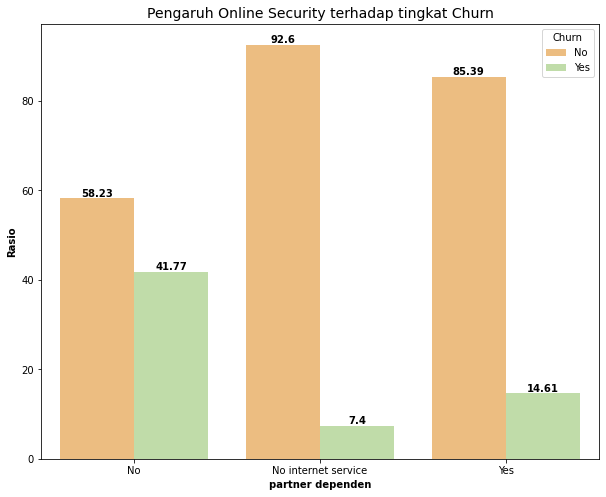

In [13]:
#Variabel online security apakah mempengaruhi churn atau tidaknya customer
online_sec=df.groupby(['OnlineSecurity','Churn']).agg({'customerID':'nunique'}).reset_index()
group_os=df.groupby('OnlineSecurity').agg({'customerID':'nunique'}).reset_index()
merge_on_group=online_sec.merge(group_os, on='OnlineSecurity')
merge_on_group['ratio']=merge_on_group['customerID_x']/merge_on_group['customerID_y']*100
merge_on_group['ratio']=round(merge_on_group['ratio'],2)


plt.figure(figsize=(10,8))
ax=sns.barplot(x='OnlineSecurity', y='ratio', hue='Churn', data=merge_on_group, palette='Spectral')
for j in ax.containers:
    ax.bar_label(j, fontsize=10, fontweight='bold')
plt.title('Pengaruh Online Security terhadap tingkat Churn',fontsize=14)
plt.xlabel('partner dependen',fontweight='bold')
plt.ylabel('Rasio', fontweight='bold');

Dari grafik diatas terdapat beberapa informasi yaitu:
- Bahwa customer dengan kategori "No internet service" memiliki tingkat churn yang sangat rendah yakni sebesar 7,4% dan memiliki tingkat tidak churn sebesar 92,6%.
- Sedangkan customer yang memiliki kategori Online Security "No" memiliki tingkat churn yang paling besar yaitu sebesar 41,77%.

In [ ]:
#Variabel online security apakah mempengaruhi churn atau tidaknya customer
online_sec=df.groupby(['OnlineSecurity','Churn']).agg({'customerID':'nunique'}).reset_index()
group_os=df.groupby('OnlineSecurity').agg({'customerID':'nunique'}).reset_index()
merge_on_group=online_sec.merge(group_os, on='OnlineSecurity')
merge_on_group['ratio']=merge_on_group['customerID_x']/merge_on_group['customerID_y']*100
merge_on_group['ratio']=round(merge_on_group['ratio'],2)


plt.figure(figsize=(10,8))
ax=sns.barplot(x='OnlineSecurity', y='ratio', hue='Churn', data=merge_on_group, palette='Spectral')
for j in ax.containers:
    ax.bar_label(j, fontsize=10, fontweight='bold')
plt.title('Pengaruh Online Security terhadap tingkat Churn',fontsize=14)
plt.xlabel('partner dependen',fontweight='bold')
plt.ylabel('Rasio', fontweight='bold');

--------------------------------------------------------------------------------------------------

data diatas imbalance karena terjadi ketimpangan antara user yang churn dan tidak churn, jika ingin melakukan klasifikasi terdapat beberapa solusi penangannya:
1. Data dibuat balance terlebih dahulu, yakni berimbang antara yang satu dengan yang lainnya dengan cara menghapus data yang berjumlah banyak dengan random atau diduplicated data yang sedikit dengan random.
2. Menggunakan Confusion Matrix

# DATA PREPROCESSING

In [ ]:
# Melakukan kerangka data baru
data1= pd.DataFrame(columns=df.columns.unique())
data1

In [ ]:
# Melakukan encoding untuk beberapa data yang bersifat object
encod=['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn']
noencod=['customerID','SeniorCitizen','tenure','MonthlyCharges','TotalCharges']

In [ ]:
#Looping untuk encoding
for i in encod:
    kond= [(df[i]=='Male'),(df[i]=='Female'),(df[i]=='Yes'),(df[i]=='No'),(df[i]=='No internet service'),(df[i]==''),(df[i]=='Month-to-month'),(df[i]=='Two year'),(df[i]=='Electronic check'),(df[i]=='Mailed check')]
    beta=[1,0,1,0,2,4,0,1,0,1]
    data1[i]=np.select(kond, beta, default=3)
for j in noencod:
    data1[j]=df[j]
display(data1)

In [ ]:
data1['TotalCharges'].replace(' ', np.nan, inplace=True)
data1.dropna(subset=['TotalCharges'], inplace=True)

In [ ]:
data1.sort_values(by=['TotalCharges'])

In [ ]:
data2=data1[['tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod','Churn']]
data2.corr()

Pada hasil visualisasi diatas menunjukkan bahwa variabel target (Churn) hanya memiliki 1 korelasi positif yakni dengan variabel Internet Service, sedangkan korelasi negatif terbesar yakni pada variabel tenure.

1. Pengujian ML yang akan digunakan adalah Decision Tree, Random Forest dan SVM karena data-data yang tersedia yakni campuran antara numeric dan kategorikal

## MACHINE LEARNING

In [ ]:
X = data1.drop(columns=["customerID","Churn"])
y = data1[["Churn"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
#Jumlah data train dan data test
print('data train:',X_train.shape)
print('data test',X_test.shape)

**Decision Tree**

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
conf=confusion_matrix(y_pred, y_test)
conf

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
print(accuracy_score(y_test, y_pred))

**Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=50, max_features="auto", random_state=44)
rf.fit(X_train, y_train)
y_pred1=rf.predict(X_test)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

In [ ]:
conf1=confusion_matrix(y_pred1, y_test)
conf1

In [ ]:
print(classification_report(y_test, y_pred1))

**Support Vector Machine (SVM)**

In [ ]:
classifier = SVC()
#training model
classifier.fit(X_train, y_train)
#Make the prediction
y_pred2 = classifier.predict(X_test)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(classifier.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(classifier.score(X_test, y_test)))

In [ ]:
print(classification_report(y_test, y_pred2))

In [ ]:
conf2=confusion_matrix(y_pred2, y_test)
conf2

* Alasan memilih Recall karena: kita lebih memilih False Positif lebih baik terjadi daripada False Negatif.